In [2]:
import numpy as np
import graphviz     # for visualizations

In [4]:
'''
    Draws an HMM as a finite state machine.
    
    Params:
        p: initial probabilities matrix
        A: state transition matrix
        B: observation probability matrix
        alphas: a dictionary of type character -> numeric value,
            where each character is part of the sequence's alphabet
        state_labels: a list of the available states
    Returns:
        graphviz.Digraph
'''
def draw_hmm(p, A, B, alphas, state_labels):
    f = graphviz.Digraph('finite_state_machine', 'fsm.gv')
    f.attr('node', shape='rarrow')
    f.node('START')
    f.attr(rankdir='LR')    # left to right

    inversed_alphas = {v: k for k, v in alphas.items()}
    
    labels = [ [] for _ in range(len(state_labels)) ]
    for i in range(B.shape[0]):
        labels[i].append(f'{state_labels[i]}|')
        for j in range(B.shape[1]):
                labels[i].append(f'{inversed_alphas[j]} {B[i, j]}')
        labels[i] = '|'.join(labels[i])
    
    f.attr('node', shape='record', **{'width':str(1), 'height':str(1)})
    
    for i in range(len(state_labels)):
        f.node(state_labels[i], label=labels[i])
    
    vals = [float(v) for v in p]
    for i in range(len(p)):
        f.edge('START', state_labels[i], str(vals[i]))
    
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            f.edge(state_labels[i], state_labels[j], str(float(A[i, j])))
            
    return f

In [5]:
'''
    Draws the given trellis.
    
    Params:
        seq: input sequence
        draw_best_path: if true then colors the best_path's corresponding cells as red
        best_path: if draw_best_path is true then it requires best_path to not be None
'''
def draw_trellis(trellis, alphas, state_labels, seq, draw_best_path=False, best_path=None):
    f = graphviz.Digraph('trellis_diagram', 'td.gv', engine='neato')
    f.attr('node', shape='none')

    f.attr(size=str(len(state_labels)) * len(seq))

    seq_len = len(seq)
    states_no = len(state_labels)
    
    for i in range(1, states_no + 1):
        f.node(name=f'st{i}', label=state_labels[i - 1], pos=f'{0},{-i}!')

    inversed_alphas = {v: k for k, v in alphas.items()}
    for i in range(seq_len):
        f.node(name=str(i), label=inversed_alphas[seq[i]], pos=f'{i + 1},{0}!')
    
    for i in range(states_no):
        for j in range(seq_len):
            if draw_best_path and best_path is not None and i == state_labels.index(best_path[j]):
                f.node(name=f'tr{i},{j}', label=str(round(trellis[i, j], 2)), pos=f'{j + 1},{-i - 1}!', color='red', style='filled')
            else:
                f.node(name=f'tr{i},{j}', label=str(round(trellis[i, j], 2)), pos=f'{j + 1},{-i - 1}!')
    return f

In [6]:
import operator

'''
    Implementation of the viterbi algorithm. Finds the best path from given params.
    
    Params:
        p: initial probabilities matrix
        A: state transition matrix
        B: observation probability matrix
        in_seq: the input sequence
        scale: whether to use logarithms instead of probs for the trellis values
        zero_replacer: specify how to replace the zeros to avoid inf/invalid/underflows that occur when multiplying very small values
        return_trellis: if true returns the created trellis
    Returns:
        a list of 3 items
        [ best_path, best_path_score, None ], if return_trellis is False
        [ best_path, best_path_score, trellis ], otherwise
'''
def viterbi(p, A, B, in_seq, scale=True, zero_replacer=0.00001, return_trellis=False):
    # is scale is True then change the operator to addition instead of multiplication
    if scale:
        op = operator.add
        p[p == 0.0] = zero_replacer
        p = np.log2(p)
        A[A == 0.0] = zero_replacer
        A = np.log2(A)
        B[B == 0.0] == zero_replacer
        B = np.log2(B)
    else:
        op = operator.mul
    
    seq_len = len(in_seq)
    states_no = p.shape[0]  # number of states
    
    trellis = np.zeros((states_no, seq_len))
    #ptrs = np.zeros((states_no, seq_len), dtype=np.int8)
    
    for state in range(states_no):
        trellis[state, 0] = op(p[state], B[state, in_seq[state]])
    
    # main body
    for i in range(1, seq_len):
        for state in range(states_no):
            k = np.argmax([ op(op(trellis[k, i - 1], A[k, state]), B[state, in_seq[i]]) for k in range(states_no) ])
            trellis[state, i] = op(op(trellis[k, i - 1], A[k, state]), B[state, in_seq[i]])
            #ptrs[state, i] = k
    
    best_path = []
    score = max([trellis[state, seq_len - 1] for state in range(states_no)])
    
    for i in range(seq_len):
        best_path.append(np.argmax([ trellis[state, i] for state in range(states_no) ]))
    
    if return_trellis:
        return [best_path, score, trellis]
    return [best_path, score, None]

In [7]:
alphas = { 'A': 0, 'G': 1, 'T': 2, 'C': 3 }
state_labels = ['a', 'b']

p = np.mat([0.5, 0.5]).T

A = np.mat([
    [9/10, 1/10], [1/10, 9/10]
]).T

B = np.mat([
    [2/5, 1/5],
    [2/5, 1/5],
    [1/10, 3/10],
    [1/10, 3/10]
]).T

print(f'{p=}', f'{p.shape=}\n')
print(f'{A=}', f'{A.shape=}\n')
print(f'{B=}', f'{B.shape=}\n')

p=matrix([[0.5],
        [0.5]]) p.shape=(2, 1)

A=matrix([[0.9, 0.1],
        [0.1, 0.9]]) A.shape=(2, 2)

B=matrix([[0.4, 0.4, 0.1, 0.1],
        [0.2, 0.2, 0.3, 0.3]]) B.shape=(2, 4)



In [8]:
seq = np.array([alphas[s] for s in 'GGCT'])
print(f'{seq=}')

print(f'seq_len:{len(seq)}, states_no:{p.shape[0]}')

seq=array([1, 1, 3, 2])
seq_len:4, states_no:2


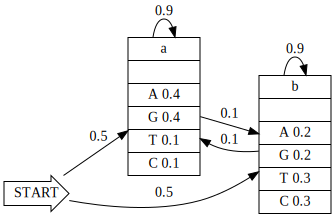

In [9]:
draw_hmm(p, A, B, alphas, state_labels)

In [10]:
[best_path, score, trellis] = viterbi(p, A, B, seq, scale=True, return_trellis=True)

In [11]:
best_path = ''.join([state_labels[state_id] for state_id in best_path])
print(f'{best_path=} -> {score=}')

best_path='aaab' -> score=-9.573796658442287


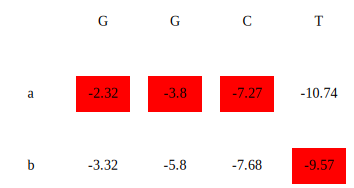

In [12]:
draw_trellis(trellis, alphas, state_labels, seq, draw_best_path=True, best_path=best_path)